# Customer Segmentation using Neural Networks


## Introduction

### Context
An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market.

### Content
In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers.

You are required to help the manager to predict the right group of the new customers.

### Acknowledgements & Inspiration
[Janatahack: Customer Segmentation](https://datahack.analyticsvidhya.com/contest/janatahack-customer-segmentation/#ProblemStatement)

### Attribute Information

| Attribute | Description   | Key   |
|-----------|---------------|-------|
| ID        | Unique ID     |       |
| Gender    | Gender of the customer| Male, Female |
| Ever_Married | Was the customer ever married? | Yes, No |
| Age       | Age of the customer | |
| Graduated | Is the customer a graduate? | Yes, No |
| Profession| Profession of the customer |  |
| Work_Experience | Work experience in years | |
| Spending_Score  | Spending score of the customer | |
| Family_Size   | Number of family memebrs for the customer (including the customer) | |
| Var_1     | Anonymised Category for the customer | |


### 1. Import Python Packages & Load Dataset

In [4624]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4625]:
# Load Dataset

train_df = pd.read_csv('customers_train.csv')
test_df = pd.read_csv('customers_test.csv')


* __what are we trying to predict?__

In [4626]:
test_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [4627]:
train_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4628]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4629]:
# store numeric data types in new variable
num_features = train_df.select_dtypes(exclude=[np.object])
print('Numeric feaures: %s' % num_features.columns)

# store categorical data types in new variable
cat_features = train_df.select_dtypes(include=[np.object])
#cat_features = cat_features.drop('Segmentation', axis=1)
print('Categorical features: %s' % cat_features.columns)

Numeric feaures: Index(['ID', 'Age', 'Work_Experience', 'Family_Size'], dtype='object')
Categorical features: Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1', 'Segmentation'],
      dtype='object')


In [4630]:
num_features.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [4631]:
cat_features.describe()

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


### 2. Cleaning Data



In [4632]:
train_unique = train_df['ID'].nunique()
test_unique = test_df['ID'].nunique()

In [4633]:
print('Unique ID values in the training data: {}'.format(train_unique))
print('Unique ID values in the test data: {}'.format(test_unique))
print('Therefore we should find {} unique ID values in the combined dataset.'.format(train_unique + test_unique))

Unique ID values in the training data: 8068
Unique ID values in the test data: 2627
Therefore we should find 10695 unique ID values in the combined dataset.


In [4634]:
df=pd.concat([train_df,test_df],axis=0)
df.shape
combined_unique = df['ID'].nunique()

In [4635]:
print('Unique ID values in the combined dataset: {}'.format(combined_unique))

Unique ID values in the combined dataset: 8363


I expected to see 10,695 unique IDs in the combined dataset, however, there are only 8,363 unique IDs. This means we have __2,332 duplicates__ in the training and test data. 

### Remove Duplicates in Training Data

In [4636]:
# Add a new column to label train or test data

#train_df['train_or_test'] = 'train'
#test_df['train_or_test'] = 'test'
#merged = pd.concat([train_df, test_df], axis=0)
#merged.shape

In [4637]:
#merged.head()

In [4638]:
#merged['train_or_test'].value_counts()

In [4639]:
#merged = merged.drop_duplicates(subset=['ID'], keep='last')

In [4640]:
#merged['train_or_test'].value_counts()

The test values do not have `segmentation` values. Next, split train and test data.

In [4641]:
#train = merged.loc[merged['train_or_test']=='train']

In [4642]:
#train.shape

We have successfully removed the duplicates from the training data. We no longer need the `train_or_test` column so we will drop this from __train__ & __test__ dataframe.

In [4643]:
#train = train.drop(columns='train_or_test')
#train.columns

In [4644]:
#test = test_df.drop(columns='train_or_test')
#test.columns

## Exploratory Analysis

In [4645]:
segment_count = train_df['Segmentation'].value_counts()
print(segment_count)

D    2268
A    1972
C    1970
B    1858
Name: Segmentation, dtype: int64


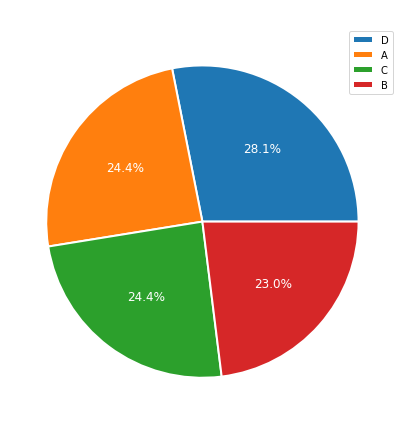

In [4646]:
fig, ax = plt.subplots(figsize=(11,6))
patches, texts, pcts = ax.pie(segment_count, labels=segment_count.index, autopct='%.1f%%', wedgeprops={'linewidth':2, 'edgecolor':'white'}, textprops={'size': 'large'})
ax.set_title('Breakdown of Customer Segmentation', fontsize=18, color='white')
plt.legend()
plt.setp(texts, color='white', fontweight=600)
plt.setp(pcts, color='white')
plt.tight_layout()
plt.show()

* __training data is balanced__

## Dealing with Missing Values

In [4647]:
train_df.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [4648]:
#cat_dummies = pd.get_dummies(cat_features,drop_first=True)
#cat_dummies.head()

le = LabelEncoder()
train_enc = train_df.copy()
for i in cat_features.columns:
    train_enc[i] = le.fit_transform(train_df[i])

In [4649]:
train_enc.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1,0,22,0,5,1.0,2,4.0,3,3
1,462643,0,1,38,1,2,NaN,0,3.0,3,0
2,466315,0,1,67,1,2,1.0,2,1.0,5,1
3,461735,1,1,67,1,7,0.0,1,2.0,5,1
4,462669,0,1,40,1,3,NaN,1,6.0,5,0


In [4650]:
#train = train.drop(columns=cat_features, axis=1)
#train = pd.concat([train, cat_dummies], axis=1)
#train.head()

In [4651]:
#le = LabelEncoder()
#train['Segmentation'] = le.fit_transform(train['Segmentation'])
#train.head()

Another critical point here is that the KNN Imptuer is a distance-based imputation method and it requires us to normalize our data. Otherwise, the different scales of our data will lead the KNN Imputer to generate biased replacements for the missing values. For simplicity, we will use Scikit-Learn’s MinMaxScaler which will scale our variables to have values between 0 and 1.

In [4652]:
scaler = MinMaxScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(train_enc), columns=train_enc.columns)
scaled_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,0.425601,1.0,0.0,0.056338,0.0,0.555556,0.071429,1.0,0.375,0.428571,1.000000
1,0.407140,0.0,0.5,0.281690,0.5,0.222222,NaN,0.0,0.250,0.428571,0.000000
2,0.815503,0.0,0.5,0.690141,0.5,0.222222,0.071429,1.0,0.000,0.714286,0.333333
3,0.306161,1.0,0.5,0.690141,0.5,0.777778,0.000000,0.5,0.125,0.714286,0.333333
4,0.410031,0.0,0.5,0.309859,0.5,0.333333,NaN,0.5,0.625,0.714286,0.000000


Now that our dataset has dummy variables and normalized, we can move on to the KNN Imputation. Let’s import it from Scikit-Learn’s Impute package and apply it to our data. In this example, we are setting the parameter ‘n_neighbors’ as 5. So, the missing values will be replaced by the mean value of 5 nearest neighbors measured by Euclidean distance.

In [4653]:
imputer = KNNImputer(n_neighbors=2, weights='distance')
scaled_train = pd.DataFrame(imputer.fit_transform(scaled_train), columns=scaled_train.columns)

In [4654]:
scaled_train.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

* __Further Work: Measuring Accuracy of KNNImputer__

In [4655]:
### unscale data 

final_train = pd.DataFrame(scaler.inverse_transform(scaled_train), columns=scaled_train.columns)
final_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809.0,1.0,0.0,22.0,0.0,5.0,1.00000,2.0,4.0,3.0,3.0
1,462643.0,0.0,1.0,38.0,1.0,2.0,1.00000,0.0,3.0,3.0,0.0
2,466315.0,0.0,1.0,67.0,1.0,2.0,1.00000,2.0,1.0,5.0,1.0
3,461735.0,1.0,1.0,67.0,1.0,7.0,0.00000,1.0,2.0,5.0,1.0
4,462669.0,0.0,1.0,40.0,1.0,3.0,6.61212,1.0,6.0,5.0,0.0


### Do the same for test dataframe

In [4656]:
test_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


In [4657]:
# store numeric data types in new variable
num_features_test = test_df.select_dtypes(exclude=[np.object])

# store categorical data types in new variable
cat_features_test = test_df.select_dtypes(include=[np.object])

#label encode categorical features
test_enc = test_df.copy()
for i in cat_features_test.columns:
    test_enc[i] = le.fit_transform(test_df[i])

#cat_dummies_test = pd.get_dummies(cat_features_test,drop_first=True)

#store new columns in test dataframe 
#test_df = test_df.drop(columns=cat_features_test, axis=1)
#test_df = pd.concat([test_df, cat_dummies_test], axis=1)
#test_df.head()

In [4658]:
test_enc.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,0,1,36,1,2,0.0,2,1.0,5
1,458994,1,1,37,1,5,8.0,0,4.0,5
2,458996,0,1,69,0,9,0.0,2,1.0,5
3,459000,1,1,59,0,4,11.0,1,2.0,5
4,459001,0,0,19,0,8,NaN,2,4.0,5


In [4659]:
# Use MinMaxScaler to scale the variables between 0 and 1
scaled_test = pd.DataFrame(scaler.fit_transform(test_enc), columns=test_enc.columns)

In [4660]:
# Use KNNImputer to replace missing variables
scaled_test = pd.DataFrame(imputer.fit_transform(scaled_test), columns=scaled_test.columns)

In [4661]:
# Check null values
scaled_test.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

In [4662]:
## unscale data and store into a new dataframe

final_test = pd.DataFrame(scaler.inverse_transform(scaled_test), columns=scaled_test.columns)
final_test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989.0,0.0,1.0,36.0,1.0,2.0,0.000000,2.0,1.0,5.0
1,458994.0,1.0,1.0,37.0,1.0,5.0,8.000000,0.0,4.0,5.0
2,458996.0,0.0,1.0,69.0,0.0,9.0,0.000000,2.0,1.0,5.0
3,459000.0,1.0,1.0,59.0,0.0,4.0,11.000000,1.0,2.0,5.0
4,459001.0,0.0,0.0,19.0,0.0,8.0,0.445328,2.0,4.0,5.0


__We have successfully replaced all the missing values in the test dataframe__ 

## Build Models

In [4663]:
X = final_train.drop('Segmentation', axis=1)
y = final_train['Segmentation']

In [4664]:
from sklearn.model_selection import train_test_split

In [4665]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2 )

### KNeighbors

In [4666]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_kn = std_scaler.transform(X_train)
X_test_kn = std_scaler.transform(X_test)

In [4667]:
### KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train_kn, y_train)
y_pred_knn = knn.predict(X_test_kn)
acc_knn = round(knn.score(X_train_kn, y_train) * 100, 2)
acc_knn

73.27

In [4668]:
## Evaluate Model
from sklearn.metrics import confusion_matrix, classification_report
cr_knn = classification_report(y_test, y_pred_knn)
print(cr_knn)

              precision    recall  f1-score   support

         0.0       0.36      0.54      0.43       407
         1.0       0.30      0.38      0.33       352
         2.0       0.44      0.30      0.36       387
         3.0       0.72      0.43      0.54       468

    accuracy                           0.42      1614
   macro avg       0.45      0.41      0.42      1614
weighted avg       0.47      0.42      0.42      1614



In [4669]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(knn, X_test, y_test, cv=3))

[0.32342007 0.2732342  0.30111524]


In [4670]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

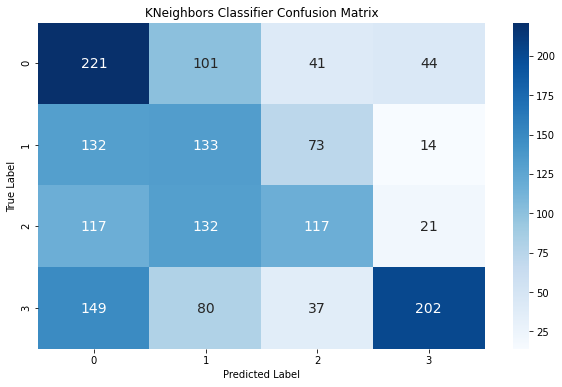

In [4671]:
plt.figure(figsize=(10,6))
sns.heatmap(cm_knn, annot=True, annot_kws={'size':14}, cmap='Blues',fmt='g')
plt.title('KNeighbors Classifier Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Decision Tree Classifier

In [4672]:
from sklearn.tree import DecisionTreeClassifier

In [4673]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [4674]:
dtc = DecisionTreeClassifier(max_depth=25, max_features=0.7, random_state=1)
model_dtc=dtc.fit(X_train, y_train)

dtc.fit(X_train, y_train)
y_pred_dt = dtc.predict(X_test)
acc_decision_tree = round(dtc.score(X_train, y_train) * 100, 2)
acc_decision_tree

99.91

In [4675]:
cr_dt = classification_report(y_test, y_pred_dt)
print(cr_dt)

              precision    recall  f1-score   support

         0.0       0.41      0.39      0.40       407
         1.0       0.33      0.36      0.35       352
         2.0       0.48      0.45      0.46       387
         3.0       0.62      0.64      0.63       468

    accuracy                           0.47      1614
   macro avg       0.46      0.46      0.46      1614
weighted avg       0.47      0.47      0.47      1614



In [4676]:
print(cross_val_score(dtc, X_test, y_test, cv=3))

[0.38104089 0.47769517 0.39219331]


In [4677]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

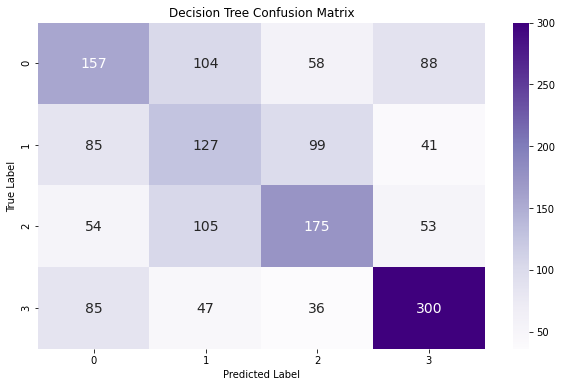

In [4678]:
plt.figure(figsize=(10,6))
sns.heatmap(cm_dt, annot=True, annot_kws={'size':14}, cmap='Purples',fmt='g')
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [4679]:
#from sklearn.tree import plot_tree

#plt.figure(figsize=(15,10))
#plt.title('Decision Tree')
#plot_tree(model_dtc, feature_names=X_train.columns, filled=True, rounded = True,fontsize= 16)

In [4680]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=25)
rfc.fit(X_train, y_train)
y_pred_rf = rfc.predict(X_test)
rfc.score(X_train, y_train)
acc_random_forest = round(rfc.score(X_train, y_train) * 100, 2)
acc_random_forest

100.0

In [4681]:
cr_rf = classification_report(y_test, y_pred_rf)
print(cr_rf)

              precision    recall  f1-score   support

         0.0       0.47      0.49      0.48       407
         1.0       0.41      0.37      0.39       352
         2.0       0.56      0.52      0.54       387
         3.0       0.65      0.72      0.68       468

    accuracy                           0.54      1614
   macro avg       0.52      0.52      0.52      1614
weighted avg       0.53      0.54      0.53      1614



In [4682]:
print(cross_val_score(rfc, X_test, y_test, cv=3))

[0.45167286 0.52230483 0.47211896]


In [4683]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

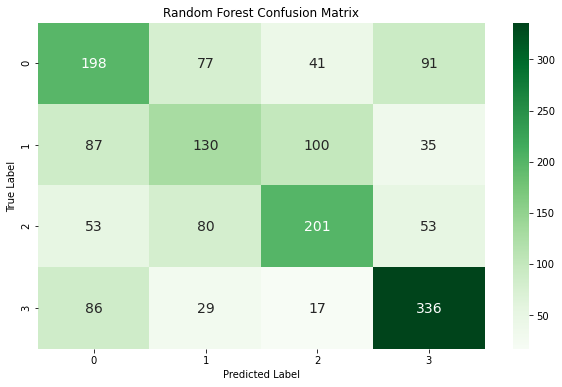

In [4684]:
plt.figure(figsize=(10,6))
sns.heatmap(cm_rf, annot=True, annot_kws={'size':14}, cmap='Greens',fmt='g')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Neural Networks

In [4685]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_nn = std_scaler.transform(X_train)
X_test_nn = std_scaler.transform(X_test)

In [4686]:
### Neural Networks

mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=600, activation='tanh', learning_rate='adaptive', learning_rate_init=0.001, solver='adam', random_state=1)

In [4687]:
mlp.fit(X_train_nn, y_train)
y_pred_mlp = mlp.predict(X_test_nn)
mlp.score(X_train_nn,y_train)
acc_mlp = round(mlp.score(X_train_nn, y_train) * 100,2)
acc_mlp

98.81

In [4688]:
cr_mlp = classification_report(y_test, y_pred_mlp)
print(cr_mlp)

              precision    recall  f1-score   support

         0.0       0.39      0.36      0.37       407
         1.0       0.31      0.35      0.33       352
         2.0       0.49      0.45      0.47       387
         3.0       0.59      0.60      0.59       468

    accuracy                           0.45      1614
   macro avg       0.44      0.44      0.44      1614
weighted avg       0.45      0.45      0.45      1614



In [4689]:
print(cross_val_score(mlp, X_test, y_test, cv=3))

[0.2527881  0.28996283 0.28996283]


In [4690]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

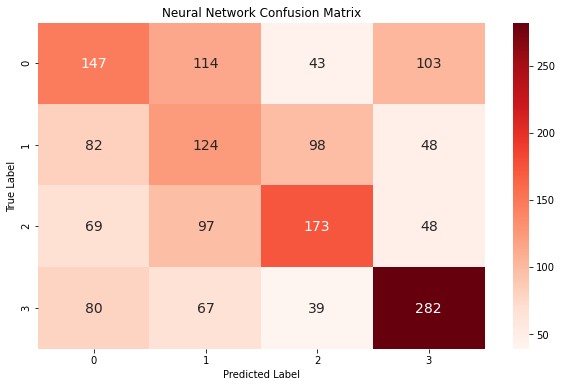

In [4691]:
plt.figure(figsize=(10,6))
sns.heatmap(cm_mlp, annot=True, annot_kws={'size':14}, cmap='Reds',fmt='g')
plt.title('Neural Network Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()